# Training a Multimodal Network for the AVLetters Dataset

This guide describes how to train a multimodal network using raw, dct features and difference of images as input sources.

## Prerequisites

We assume the following config file `trimodal.ini` is used. All finetuned DBNF extractors for raw and difference of image are saved in the respective files defined in the config file:

```ini
[general]
disable_matplotlib: true

[data]
images: data/resized.mat
dct: data/dctFeat_matlab_AVLetters.mat
diff: data/resized_diff_image_AVLetters.mat

[models]
pretrained: models/avletters_ae.mat
finetuned: models/avletters_ae_finetune.dat
pretrained_diff: models/avletters_ae_diff_image.mat
finetuned_diff: models/avletters_ae_finetune_diff_image.dat
fusiontype: sum

[training]
learning_rate: 2.0
decay_rate: 0.8
decay_start: 10
do_finetune = false
save_finetune = false
load_finetune = true
load_finetune_diff = true
```

## Import python packages

In [43]:
%matplotlib inline
from __future__ import print_function
import sys
sys.path.insert(0, '../')
import os
import time
import cPickle as pickle
import logging
import ConfigParser
import argparse

import theano.tensor as T
import theano

import matplotlib
# matplotlib.use('Agg')  # Change matplotlib backend, in case we have no X server running..

from utils.preprocessing import *
from utils.plotting_utils import *
from utils.data_structures import circular_list
from utils.datagen import *
from utils.io import *
from utils.draw_net import *
from custom_layers.custom import DeltaLayer
from modelzoo import adenet_v1, deltanet, adenet_v2, adenet_v3, adenet_v4, adenet_v5, adenet_v6

import numpy as np
from lasagne.layers import InputLayer, DenseLayer, DropoutLayer, LSTMLayer, Gate, ElemwiseSumLayer, SliceLayer
from lasagne.layers import ReshapeLayer, DimshuffleLayer, ConcatLayer, BatchNormLayer, batch_norm
from lasagne.nonlinearities import tanh, linear, sigmoid, rectify, leaky_rectify
from lasagne.updates import nesterov_momentum, adadelta, sgd, norm_constraint
from lasagne.objectives import squared_error
from nolearn.lasagne import NeuralNet

## Configure theano

Configure theano to use `float32` as default float size so it is compatible to gpus, increase the recursion depth to 10000.

In [27]:
def configure_theano():
    theano.config.floatX = 'float32'
    sys.setrecursionlimit(10000)
    
configure_theano()

## Define a Method to Evaluate the Learnt Model

In [28]:
def evaluate_model(X_val, y_val, mask_val, dct_val, diff_val, window_size, eval_fn):
    """
    Evaluate a lstm model
    :param X_val: validation inputs
    :param y_val: validation targets
    :param mask_val: input masks for variable sequences
    :param dct_val: dct features
    :param diff_val: diff image features
    :param window_size: size of window for computing delta coefficients
    :param eval_fn: evaluation function
    :return: classification rate, confusion matrix
    """
    output = eval_fn(X_val, mask_val, dct_val, diff_val, window_size)
    no_gps = output.shape[1]
    confusion_matrix = np.zeros((no_gps, no_gps), dtype='int')

    ix = np.argmax(output, axis=1)
    c = ix == y_val
    classification_rate = np.sum(c == True) / float(len(c))

    # construct the confusion matrix
    for i, target in enumerate(y_val):
        confusion_matrix[target, ix[i]] += 1

    return classification_rate, confusion_matrix

## Load Config File

In [29]:
config_file = 'config/trimodal.ini'
config = ConfigParser.ConfigParser()
config.read(config_file)

print('Reading Config File: {}...'.format(config_file))
print(config.items('data'))
print(config.items('models'))
print(config.items('training'))

Reading Config File: config/trimodal.ini...
[('images', 'data/resized.mat'), ('dct', 'data/dctFeat_matlab_AVLetters.mat'), ('diff', 'data/resized_diff_image_AVLetters.mat')]
[('pretrained', 'models/avletters_ae.mat'), ('finetuned', 'models/avletters_ae_finetune.dat'), ('pretrained_diff', 'models/avletters_ae_diff_image.mat'), ('finetuned_diff', 'models/avletters_ae_finetune_diff_image.dat'), ('fusiontype', 'sum')]
[('learning_rate', '2.0'), ('decay_rate', '0.8'), ('decay_start', '10'), ('do_finetune', 'false'), ('save_finetune', 'false'), ('load_finetune', 'true'), ('load_finetune_diff', 'true')]


## Preprocess Input Sources

Note that the `.mat` files are loaded as python `dict` and we assume they are named according to the code. In this case, the raw images are already samplewise normalized so there is no need to normalize them again. However if there is a need to do that, you can call the following procedure:

```python
# samplewise normalize
print('sameplewise mean normalize...')
data_matrix = normalize_input(data_matrix)
diff_data_matrix = normalize_input(diff_data_matrix)
diff_data_matrix = compute_diff_images(data_matrix, vid_len_vec.reshape((-1,))).astype('float32')
```

In [30]:
print('loading data and configs...')
data = load_mat_file(config.get('data', 'images'))
dct_data = load_mat_file(config.get('data', 'dct'))
diff_data = load_mat_file(config.get('data', 'diff'))
ae_pretrained = config.get('models', 'pretrained')
ae_finetuned = config.get('models', 'finetuned')
ae_finetuned_diff = config.get('models', 'finetuned_diff')
fusiontype = config.get('models', 'fusiontype')
learning_rate = float(config.get('training', 'learning_rate'))
decay_rate = float(config.get('training', 'decay_rate'))
decay_start = int(config.get('training', 'decay_start'))
do_finetune = config.getboolean('training', 'do_finetune')
save_finetune = config.getboolean('training', 'save_finetune')
load_finetune = config.getboolean('training', 'load_finetune')
load_finetune_diff = config.getboolean('training', 'load_finetune_diff')

# create the necessary variable mappings
data_matrix = data['dataMatrix']
data_matrix_len = data_matrix.shape[0]
targets_vec = data['targetsVec']
vid_len_vec = data['videoLengthVec']
iter_vec = data['iterVec']
dct_feats = dct_data['dctFeatures']
diff_data_matrix = diff_data['dataMatrix']

print('data and configs loaded...')

loading data and configs...
data and configs loaded...


## Split the data to training and test sets

In [31]:
indexes = create_split_index(data_matrix_len, vid_len_vec, iter_vec)
train_vidlen_vec, test_vidlen_vec = split_videolen(vid_len_vec, iter_vec)
assert len(train_vidlen_vec) == 520
assert len(test_vidlen_vec) == 260
assert np.sum(vid_len_vec) == data_matrix_len

# split the data
train_data = data_matrix[indexes == True]
train_targets = targets_vec[indexes == True]
train_targets = train_targets.reshape((len(train_targets),))
test_data = data_matrix[indexes == False]
test_targets = targets_vec[indexes == False]
test_targets = test_targets.reshape((len(test_targets),))
train_diff_data = diff_data_matrix[indexes == True]
test_diff_data = diff_data_matrix[indexes == False]
print('Data split complete...')

Data split complete...


## Perform Featurewise normalization on DCT Features

To speed up training time, Hinton (2010) suggested normalizing the training inputs to 0 mean and standard deviation of 1. We apply this to the DCT Features using the following procedure:

### Reference
Hinton, G. (2010). A practical guide to training restricted Boltzmann machines. Momentum, 9(1), 926.

In [32]:
# split the dct features + featurewise mean normalize
train_dct = dct_feats[indexes == True].astype(np.float32)
test_dct = dct_feats[indexes == False].astype(np.float32)
train_dct, dct_mean, dct_std = featurewise_normalize_sequence(train_dct)
test_dct = (test_dct - dct_mean) / dct_std
print('normaliztion complete...')

normaliztion complete...


## Notes on Finetuning
We assume the models have already been finetuned by if they are not finetuned, the following procedure can be used to perform finetuining, refer to the code `avletters/trimodal.py` for more details of finetuning. Note that the variables `ae_pretrained`, `ae_finetuned`, `do_finetune`, `save_finetune` can all be defined in the config file.

```python
do_finetune = True
save_finetune = True
if do_finetune:
    print('fine-tuning...')
    ae = load_dbn(ae_pretrained)
    ae.initialize()
    ae.fit(train_data, train_data)
    res = ae.predict(test_data)
    # print(res.shape)
    visualize_reconstruction(test_data[300:336], res[300:336])

if save_finetune:
    pickle.dump(ae, open(ae_finetuned, 'wb'))
```

## Load Finetuned Models

Now we load the already finetuned models for raw images and difference of images based on the config file.

In [33]:
print('loading pre-trained encoding layers...')
ae = pickle.load(open(ae_finetuned, 'rb'))
ae.initialize()

print('loading pre-trained diff image encoding layers...')
diff_ae = pickle.load(open(ae_finetuned_diff, 'rb'))
diff_ae.initialize()

print('all finetuned models loaded...')

loading pre-trained encoding layers...
loading pre-trained diff image encoding layers...
all finetuned models loaded...


## Constructing the Model

The following steps will create the End to End model using Theano. 

### Define Model Variables
We first define the necessary theano variables to describe the model.

In [34]:
inputs_raw = T.tensor3('inputs_raw', dtype='float32')
inputs_diff = T.tensor3('inputs_diff', dtype='float32')
window = T.iscalar('theta')
dct = T.tensor3('dct', dtype='float32')
mask = T.matrix('mask', dtype='uint8')
targets = T.ivector('targets')
lr = theano.shared(np.array(learning_rate, dtype=theano.config.floatX), name='learning_rate')
lr_decay = np.array(decay_rate, dtype=theano.config.floatX)

### Create Model

Next we create the model `adenet_v3` by loading the package from `modelzoo`

In [35]:
network, l_fuse = adenet_v3.create_model(ae, diff_ae, (None, None, 1200), inputs_raw,
                                             (None, None), mask,
                                             (None, None, 90), dct,
                                             (None, None, 1200), inputs_diff,
                                             250, window, 26,
                                             fusiontype)
print_network(network)

[L] raw_im: (None, None, 1200)
[L] reshape1_raw: (None, 1200)
[L] fc1_raw: (None, 2000)
[L] fc2_raw: (None, 1000)
[L] fc3_raw: (None, 500)
[L] bottleneck_raw: (None, 50)
[L] reshape2_raw: (None, None, 50)
[L] delta_raw: (None, None, 150)
[L] dropout_raw: (None, None, 150)
[L] mask: (None, None)
[L] lstm_raw: (None, None, 500)
[L] dct: (None, None, 90)
[L] dropout_dct: (None, None, 90)
[L] lstm_dct: (None, None, 500)
[L] diff_im: (None, None, 1200)
[L] reshape1_diff: (None, 1200)
[L] fc1_diff: (None, 2000)
[L] fc2_diff: (None, 1000)
[L] fc3_diff: (None, 500)
[L] bottleneck_diff: (None, 50)
[L] reshape2_diff: (None, None, 50)
[L] delta_diff: (None, None, 150)
[L] dropout_diff: (None, None, 150)
[L] lstm_diff: (None, None, 500)
[L] sum1: (None, None, 500)
[L] dropout_agg: (None, None, 500)
[L] f_lstm_agg: (None, None, 500)
[L] b_lstm_agg: (None, None, 500)
[L] sum2: (None, None, 500)
[L] slice1: (None, 500)
[L] output: (None, 26)


## Compiling the Model
Once the model has been constructed, we now compile the model by defining the cost, update and trainable parameters.

In [36]:
print('compiling model...')
predictions = las.layers.get_output(network, deterministic=False)
all_params = las.layers.get_all_params(network, trainable=True)
cost = T.mean(las.objectives.categorical_crossentropy(predictions, targets))
updates = las.updates.adadelta(cost, all_params, learning_rate=lr)

train = theano.function(
    [inputs_raw, targets, mask, dct, inputs_diff, window],
    cost, updates=updates, allow_input_downcast=True)
compute_train_cost = theano.function([inputs_raw, targets, mask, dct, inputs_diff, window],
                                     cost, allow_input_downcast=True)

test_predictions = las.layers.get_output(network, deterministic=True)
test_cost = T.mean(las.objectives.categorical_crossentropy(test_predictions, targets))
compute_test_cost = theano.function(
    [inputs_raw, targets, mask, dct, inputs_diff, window], test_cost, allow_input_downcast=True)

val_fn = theano.function([inputs_raw, mask, dct, inputs_diff, window], test_predictions, allow_input_downcast=True)
print('model compiled...')

compiling model...
model compiled...


## Training

### Set training parameters
We now create the training loop by first setting the training parameters:

In [37]:
print('begin training...')
cost_train = []
cost_val = []
class_rate = []
NUM_EPOCHS = 25
EPOCH_SIZE = 20
BATCH_SIZE = 26
WINDOW_SIZE = 9
STRIP_SIZE = 3
MAX_LOSS = 0.2
VALIDATION_WINDOW = 4
val_window = circular_list(VALIDATION_WINDOW)
train_strip = np.zeros((STRIP_SIZE,))
best_val = float('inf')
best_conf = None
best_cr = 0.0

begin training...


### Create Minibatches
Next we define the data generators to generate inputs for each minibatch, we use a random batch iterator to generate minibatches of 26 utterances for each epoch. See settings above.

In [39]:
datagen = gen_lstm_batch_random(train_data, train_targets, train_vidlen_vec, batchsize=BATCH_SIZE)
val_datagen = gen_lstm_batch_random(test_data, test_targets, test_vidlen_vec,
                                    batchsize=len(test_vidlen_vec))
integral_lens = compute_integral_len(train_vidlen_vec)

# We'll use this "validation set" to periodically check progress
X_val, y_val, mask_val, idxs_val = next(val_datagen)
integral_lens_val = compute_integral_len(test_vidlen_vec)
dct_val = gen_seq_batch_from_idx(test_dct, idxs_val, test_vidlen_vec, integral_lens_val, np.max(test_vidlen_vec))
diff_val = gen_seq_batch_from_idx(test_diff_data, idxs_val,
                                  test_vidlen_vec, integral_lens_val, np.max(test_vidlen_vec))
print('data generators created...')

data generators created...


#### Early Stopping
To avoid running unnecessary training epochs especially when the model has overfitted we define an early stopping strategy based on the paper by Prechelt (1998). The idea is to stop when the validation cost has increased consecutively for more than a predefined number of epochs (set to 4 by default).

**Reference** <br>
Prechelt, L. (1998). Early stopping-but when?. In Neural Networks: Tricks of the trade (pp. 55-69). Springer Berlin Heidelberg.

In [40]:
def early_stop(cost_window):
    if len(cost_window) < 2:
        return False
    else:
        curr = cost_window[0]
        for idx, cost in enumerate(cost_window):
            if curr < cost or idx == 0:
                curr = cost
            else:
                return False
        return True

### Begin Training Loop
We run the training for a maximum of 25 epochs with an early stopping window of 4. During each training epoch, we evaluate the model against the validation set and determine its classification rate. This is in accordance to the testing protocol defined by Zhao, G (2009).

**Reference** <br>
Zhao, G., Barnard, M., & Pietikainen, M. (2009). Lipreading with local spatiotemporal descriptors. IEEE Transactions on Multimedia, 11(7), 1254-1265.

In [41]:
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    for i in range(EPOCH_SIZE):
        X, y, m, batch_idxs = next(datagen)
        d = gen_seq_batch_from_idx(train_dct, batch_idxs,
                                   train_vidlen_vec, integral_lens, np.max(train_vidlen_vec))
        diff = gen_seq_batch_from_idx(train_diff_data, batch_idxs,
                                      train_vidlen_vec, integral_lens, np.max(train_vidlen_vec))
        print_str = 'Epoch {} batch {}/{}: {} examples at learning rate = {:.4f}'.format(
            epoch + 1, i + 1, EPOCH_SIZE, len(X), float(lr.get_value()))
        print(print_str, end='')
        sys.stdout.flush()
        train(X, y, m, d, diff, WINDOW_SIZE)
        print('\r', end='')
    cost = compute_train_cost(X, y, m, d, diff, WINDOW_SIZE)
    val_cost = compute_test_cost(X_val, y_val, mask_val, dct_val, diff_val, WINDOW_SIZE)
    cost_train.append(cost)
    cost_val.append(val_cost)
    train_strip[epoch % STRIP_SIZE] = cost
    val_window.push(val_cost)

    gl = 100 * (cost_val[-1] / np.min(cost_val) - 1)
    pk = 1000 * (np.sum(train_strip) / (STRIP_SIZE * np.min(train_strip)) - 1)
    pq = gl / pk

    cr, val_conf = evaluate_model(X_val, y_val, mask_val, dct_val, diff_val, WINDOW_SIZE, val_fn)
    class_rate.append(cr)

    print("Epoch {} train cost = {}, validation cost = {}, "
          "generalization loss = {:.3f}, GQ = {:.3f}, classification rate = {:.3f} ({:.1f}sec)"
          .format(epoch + 1, cost_train[-1], cost_val[-1], gl, pq, cr, time.time() - time_start))

    if val_cost < best_val:
        best_val = val_cost
        best_conf = val_conf
        best_cr = cr
        if fusiontype == 'adasum':
            adascale_param = las.layers.get_all_param_values(l_fuse, scaling_param=True)

    if epoch >= VALIDATION_WINDOW and early_stop(val_window):
        break

    # learning rate decay
    if epoch >= decay_start - 1:
        lr.set_value(lr.get_value() * lr_decay)

Epoch 1 train cost = 2.64442396164, validation cost = 3.11131930351, generalization loss = 0.000, GQ = 0.000, classification rate = 0.092 (104.3sec)
Epoch 2 train cost = 2.20472049713, validation cost = 2.84998130798, generalization loss = 0.000, GQ = 0.000, classification rate = 0.138 (103.9sec)
Epoch 3 train cost = 2.26433587074, validation cost = 2.66919016838, generalization loss = 0.000, GQ = 0.000, classification rate = 0.154 (113.1sec)
Epoch 4 train cost = 1.62304961681, validation cost = 2.35263562202, generalization loss = 0.000, GQ = 0.000, classification rate = 0.238 (103.7sec)
Epoch 5 train cost = 1.16199123859, validation cost = 2.45855951309, generalization loss = 4.502, GQ = 0.010, classification rate = 0.238 (108.5sec)
Epoch 6 train cost = 0.782256484032, validation cost = 2.1610159874, generalization loss = 0.000, GQ = 0.000, classification rate = 0.342 (105.7sec)
Epoch 7 train cost = 0.819062113762, validation cost = 1.751973629, generalization loss = 0.000, GQ = 0.00

### Plot Training Results
Plot the results from the training and confusion matrix. If the `fusiontype` option is set to `adasum` we display the final scaling parameters.

Best Model
classification rate: 0.634615384615, validation loss: 1.28468763828
confusion matrix: 


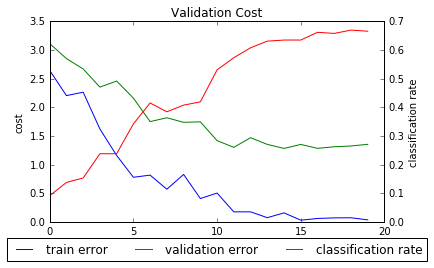

In [49]:
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g',
               'h', 'i', 'j', 'k', 'l', 'm', 'n',
               'o', 'p', 'q', 'r', 's', 't', 'u',
               'v', 'w', 'x', 'y', 'z']

print('Best Model')
print('classification rate: {}, validation loss: {}'.format(best_cr, best_val))
if fusiontype == 'adasum':
    print("final scaling params: {}".format(adascale_param))
print('confusion matrix: ')
# plot_confusion_matrix(best_conf, letters, fmt='grid')
plot_validation_cost(cost_train, cost_val, class_rate)